# Evaluation of postprocessing approaches

## Prelude
In general, nuclei instance segmentation can be formulated as a classification or a regression problem. Hence, the model's objective is to learn a segmentation mask or a distance map for the classification and regression problem, respectively. In a segmentation mask, each pixel is assigned to a certain class. Such a class might be background, nucleus, nucleus center or nucleus border. In a binary segmentation mask, each pixel represents the probability of the pixel belonging to one of the two classes (e.g., nucleus vs. background). In a distance map, each pixel stats the minimal distance between the pixel and a pixel of a certain class (i.e., commonly the background). The chessboard distance is usually used as distance measure. However, other distance measures like the Manhattan or Euclidian distance could be used as well. Moreover, the distance might be isotropically or anisotropically (i.e., in a certain direction) calculated and the distance map normalized. The manigfold design choices for indiviual and the combination of multiple segmentation masks and/or distances maps give rise to diverse postprocessing strategies.

## Aim
Here, a qualitative and quantitative evaluation of the following postprocessing approaches is presented:
- Yang et al. 2006
- Naylor et al. 2019
- Graham et al. 2019
- Noname

Furthermore, the postprocessing approaches are compared against a baseline approach incapable of separating touching/overlapping nuclei to allow for a better performance evaluation of the different postprocesing approaches.

In [1]:
from typing import Dict, List, Literal, Optional, overload, Union
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchmetrics import MetricCollection
from tqdm import tqdm
import optuna
from optuna.samplers import TPESampler
import pandas as pd
from pandas import DataFrame
from pandas.io.formats.style import Styler
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from data.MoNuSeg.data_module import MoNuSegDataModule
from evaluation.metrics import DSC, AJI, ModAJI, PQ
from postprocessing.postprocesses import SegPostProcess, DistPostProcess, HVPostProcess
from data.MoNuSeg.ground_truth import NucleiInstances
from data.MoNuSeg.illustrator import Picture
from tuning import suggest_pprocess_params, suggest_thresh

/home/ubuntu/NucInstSeg/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [168]:
data_module = MoNuSegDataModule(
    seg_masks=True,
    cont_masks=True,
    dist_maps=True,
    hv_maps=True,
    labels=True,
    train_transforms=None,
    batch_size=16,
    data_root="datasets"
)
data_module.setup(stage=None)
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

data_module = MoNuSegDataModule(
    seg_masks=True,
    cont_masks=True,
    dist_maps=True,
    hv_maps=True,
    labels=True,
    train_transforms=None,
    batch_size=32,
    data_root="datasets"
)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()

In [ ]:
train = ["TCGA-A7-A13E-01Z-00-DX1",  # Breast
             "TCGA-A7-A13F-01Z-00-DX1",  # Breast
             "TCGA-AR-A1AK-01Z-00-DX1",  # Breast
             "TCGA-AR-A1AS-01Z-00-DX1",  # Breast
             "TCGA-B0-5711-01Z-00-DX1",  # Kidney
             "TCGA-HE-7128-01Z-00-DX1",  # Kidney
             "TCGA-HE-7129-01Z-00-DX1",  # Kidney
             "TCGA-HE-7130-01Z-00-DX1",  # Kidney
             "TCGA-18-5592-01Z-00-DX1",  # Liver
             "TCGA-38-6178-01Z-00-DX1",  # Liver
             "TCGA-49-4488-01Z-00-DX1",  # Liver
             "TCGA-50-5931-01Z-00-DX1",  # Liver
             "TCGA-G9-6336-01Z-00-DX1",  # Prostate
             "TCGA-G9-6348-01Z-00-DX1",  # Prostate
             "TCGA-G9-6356-01Z-00-DX1",  # Prostate; Target for color normalization
             "TCGA-G9-6363-01Z-00-DX1"]  # Prostate

In [155]:
# @overload
# def postprocess_gt(reduction: Literal[None]) -> Dict[str, Tensor]: ...
# @overload 
# def postprocess_gt(reduction: Literal[False]) -> Dict[str, Dict[str, Tensor]]: ...
# @overload
def postprocess_gt(mode: str, pprocess_params: dict, dataloader: DataLoader, reduction: Optional[str]=None, ) -> Union[Dict[str, Tensor], Dict[str, Dict[str, Tensor]]]:
    postprocesses = {
        "baseline": SegPostProcess(mode="baseline", actv=False, seg_params=pprocess_params),
        "noname": SegPostProcess(mode="noname", actv=False, seg_params=pprocess_params),
        "yang": SegPostProcess(mode="yang", actv=False, seg_params=pprocess_params),
        "naylor": DistPostProcess(dist_params=pprocess_params),
        "graham": HVPostProcess(exprmtl=False, actv=False, hv_params=pprocess_params),
        "exprmtl": HVPostProcess(exprmtl=True, actv=False, hv_params=pprocess_params)
    }
    pprocess = postprocesses.get(mode)
    
    
    metrics = MetricCollection([
        DSC(),
        ModAJI(),
        PQ()
    ], compute_groups=False)
    
    performance = {}
    for batch_idx, gt in enumerate(dataloader):
        pred_inst = pprocess(gt)
        if reduction is None: 
            metrics.update(pred_inst, gt["inst"])
        elif reduction == "labelwise":  # Requires batch_size = 1
            label = gt["label"]
            performance[label] = metrics(pred_inst, gt["inst"])
            metrics.reset()
        elif reduction == "organwise":
            lookup = {
                "TCGA-E2-A1B5-01Z-00-DX1": "Breast",
                "TCGA-E2-A14V-01Z-00-DX1": "Breast",
                "TCGA-A7-A13E-01Z-00-DX1": "Breast",
                "TCGA-B0-5698-01Z-00-DX1": "Kidney",
                "TCGA-B0-5710-01Z-00-DX1": "Kidney",
                "TCGA-B0-5711-01Z-00-DX1": "Kidney",
                "TCGA-21-5784-01Z-00-DX1": "Liver",
                "TCGA-21-5786-01Z-00-DX1": "Liver",
                "TCGA-38-6178-01Z-00-DX1": "Liver",
                "TCGA-CH-5767-01Z-00-DX1": "Prostate",
                "TCGA-G9-6362-01Z-00-DX1": "Prostate",
                "TCGA-G9-6356-01Z-00-DX1": "Prostate",
                "TCGA-DK-A2I6-01A-01-TS1": "Bladder",
                "TCGA-G2-A2EK-01A-02-TSB": "Bladder",
                "TCGA-AY-A8YK-01A-01-TS1": "Colon",
                "TCGA-NH-A8F7-01A-01-TS1": "Colon",
                "TCGA-KB-A93J-01A-01-TS1": "Stomach",
                "TCGA-RD-A8N9-01A-01-TS1": "Stomach"
            }
            label = gt["label"]
            organ = set(lookup[l[:23]] for l in label)
            if len(organ) > 1:
                raise ValueError(f"Batch should only contain images from a single organ. Got instead {organ}.")
            organ = next(iter(organ))
            performance[organ] = metrics(pred_inst, gt["inst"])
            metrics.reset()
        else:
            raise ValueError(f"Reduction should be None, 'labelwise' or 'organwise'. Got instead {reduction}.")
            
    return metrics.compute() if reduction is None else performance

In [4]:
class PostProcessParamsTuner:
    
    def __init__(self, mode: str, default_params: dict, dataloader: DataLoader, objective: str="PQ", direction: str="maximize", n_trials: Optional[int]=None, seed: int=40):
        if not self.is_tuneable(mode):
            raise ValueError(f"Mode should be 'noname', 'yang', 'naylor', 'graham', 'exprmtl'. Got instead {self.mode}")
        self.mode = mode
        self.default_params = default_params
        self.dataloader = dataloader
        self.objective = objective
        self.direction = direction
        if n_trials is None:
            if self.mode == "noname":
                self.n_trials = 10
            elif self.mode == "yang":
                self.n_trials = 40
            elif self.mode == "naylor":
                self.n_trials = 5
            elif mode in ["graham", "exprmtl"]:
                self.n_trials = 60       
        elif isinstance(n_trials, int):
            self.n_trials = n_trials
        else:
            raise TypeError(f"Number of trials should be of type None or int. Got instead {type(n_trials)}.")
        self.seed = seed
    
    def __call__(self) -> dict:
        sampler = TPESampler(seed=self.seed)
        study = optuna.create_study(sampler=sampler, direction=self.direction)
        study.optimize(self.pparms_trial, n_trials=self.n_trials)
        return {**self.default_params, **study.best_trial.params}
    
    def pparms_trial(self, trial) -> Tensor:
        pprocess_params = {**self.default_params, **self.suggest_pprocess_params(trial, mode=self.mode)}
        scores = postprocess_gt(mode=self.mode, pprocess_params=pprocess_params, dataloader=self.dataloader, reduction=None)
        print(scores)
        return scores[self.objective]
    
    @staticmethod
    def is_tuneable(mode: str):
        return mode in ["noname", "yang", "naylor", "graham", "exprmtl"]
    
    @staticmethod
    def suggest_pprocess_params(trial, mode: str) -> dict:

        if mode == "noname":
            pprocess_params = {
                "min_marker_size": trial.suggest_int("min_marker_size", 5, 80, step=5)
            }
            

        elif mode == "yang":
            thresh_coarse = trial.suggest_int("thresh_coarse", 0, 500, step=10)
            thresh_fine = trial.suggest_int("thresh_fine", 0, thresh_coarse, step=10)
            pprocess_params = {
                "thresh_coarse": thresh_coarse,
                "thresh_fine": thresh_fine
            }

        elif mode == "naylor":
            pprocess_params = {
                "h_param": trial.suggest_int("h_param", 0, 5, step=1)
            }

        elif mode in ["graham", "exprmtl"]:
            pprocess_params = {
                "thresh_comb": suggest_thresh(trial, thresh_name="thresh_comb", range_float=(0.3, 0.7)),
                "min_marker_size": trial.suggest_int("min_marker_size", 0, 80, step=5)
            }

        return pprocess_params

In [135]:
default_pprocess_params = {
        "baseline": { 
            "min_obj_size": 0,
            "thresh_seg": None
            
        },
        "noname": {
            "min_obj_size": 0,
            "min_marker_size": 65,
            "thresh_seg": None,
            "thresh_cont": None
        },
        "yang": {
            "min_obj_size": 0,
            "thresh_seg": None,
            "thresh_coarse": 420,
            "thresh_fine": 350
        },
        "naylor": {
            "thresh_dist": 1,  # None
            "h_param": 1
        },
        "graham": {
            "min_obj_size": 0,
            "min_marker_size": 10,
            "thresh_seg": None,
            "thresh_comb": 0.55
        },
        "exprmtl": {
            "min_obj_size": 0,
            "min_marker_size": 0,
            "thresh_seg": None,
            "thresh_comb": "mean"
        }
    }

In [157]:
def eval_pprocesses(modes: Optional[List[str]]=None, tune_pprocess_params: bool=True, default_pprocess_params=default_pprocess_params):
    
    def style_performance_df(df: DataFrame, caption: str) -> Styler:
        df = df.astype(float)
        df *= 100
        df.index += " [%]"
        styler = df.style
        styler.set_caption(caption)
        styler.format_index(str.capitalize, axis=1)
        styler.format(precision=2)
        styler.highlight_max(axis=1, props="font-weight:bold")
        return styler
    
    def style_pprocess_params_df(df: DataFrame, caption: str) -> Styler:
        styler = df.style 
        df.index = [s.replace("_cat", "").replace("_float", "") for s in df.index]
        styler.set_caption("Postprocessing parameter")
        styler.format_index(str.capitalize, axis=1)
        styler.format(precision=2)
        styler.hide([s for s in df.index if "_is" in s])
        return styler
    
#     default_pprocess_params = {
#         "baseline": { 
#             "min_obj_size": 0,
#             "thresh_seg": None
            
#         },
#         "noname": {
#             "min_obj_size": 0,
#             "min_marker_size": 65,
#             "thresh_seg": None,
#             "thresh_cont": None
#         },
#         "yang": {
#             "min_obj_size": 0,
#             "thresh_seg": None,
#             "thresh_coarse":  420,
#             "thresh_fine":    350
#         },
#         "naylor": {
#             "thresh_dist": None,
#             "h_param": 1
#         },
#         "graham": {
#             "min_obj_size": 0,
#             "min_marker_size": 10,
#             "thresh_seg": None,
#             "thresh_comb": 0.55
#         },
#         "exprmtl": {
#             "min_obj_size": 0,
#             "min_marker_size": 0,
#             "thresh_seg": None,
#             "thresh_comb": "mean"
#         }
#     }

    if modes is None:
        modes = ["baseline", "noname", "yang", "naylor", "graham", "exprmtl"]
   
    val_performance, val_performance_organ, test_performance, test_performance_organ, pprocess_params = {}, {}, {}, {}, {}
    for mode in modes:
        print(f"###################### {mode.capitalize()} ######################")
        if tune_pprocess_params and PostProcessParamsTuner.is_tuneable(mode):
            print(f"Tuning postprocessing parameters for mode '{mode}' on valiation dataset.")
            pprocess_params[mode] = PostProcessParamsTuner(mode=mode, default_params=default_pprocess_params[mode], dataloader=val_loader, n_trials=None)()
        else:
            print(f"Loading default postprocessing parameters for mode '{mode}'.")
            pprocess_params[mode] = default_pprocess_params[mode]
        print(f"Calculating overall postprocessing performance for mode '{mode}' on validation dataset.")
        val_performance[mode] = postprocess_gt(mode=mode, dataloader=val_loader, pprocess_params=pprocess_params[mode], reduction=None)
        print(f"Calculating organwise postprocessing performance for mode '{mode}' on validation dataset.")
        val_performance_organ[mode] = postprocess_gt(mode=mode, dataloader=val_loader, pprocess_params=pprocess_params[mode], reduction="organwise")         
        print(f"Calculating overall postprocessing performance for mode '{mode}' on test dataset.")
        test_performance[mode] = postprocess_gt(mode=mode, dataloader=test_loader, pprocess_params=pprocess_params[mode], reduction=None)
        print(f"Calculating organwise postprocessing performance for mode '{mode}' on test dataset.")
        test_performance_organ[mode] = postprocess_gt(mode=mode, dataloader=test_loader, pprocess_params=pprocess_params[mode], reduction="organwise")
    
    return val_performance, val_performance_organ, test_performance, test_performance_organ, pprocess_params

In [169]:
val_performance, val_performance_organ, test_performance, test_performance_organ, pprocess_params = eval_pprocesses(modes=["exprmtl", "baseline"], tune_pprocess_params=False)

###################### Exprmtl ######################
Loading default postprocessing parameters for mode 'exprmtl'.
single: {'min_obj_size': 0, 'min_marker_size': 0, 'thresh_seg': None, 'thresh_comb': 'mean'}
all: {'exprmtl': {'min_obj_size': 0, 'min_marker_size': 0, 'thresh_seg': None, 'thresh_comb': 'mean'}}
######################
Calculating overall postprocessing performance for mode 'exprmtl' on validation dataset.
In postprocess_gt: {'min_obj_size': 0, 'min_marker_size': 0, 'thresh_seg': None, 'thresh_comb': 'mean'}
Calculating organwise postprocessing performance for mode 'exprmtl' on validation dataset.
In postprocess_gt: {'min_obj_size': 0, 'min_marker_size': 0, 'thresh_seg': None, 'thresh_comb': 'mean'}
Calculating overall postprocessing performance for mode 'exprmtl' on test dataset.
In postprocess_gt: {'min_obj_size': 0, 'min_marker_size': 0, 'thresh_seg': None, 'thresh_comb': 'mean'}
Calculating organwise postprocessing performance for mode 'exprmtl' on test dataset.
In po

KeyboardInterrupt: 

In [149]:
print(val_performance)
print(val_performance_organ)
print(test_performance)
print(test_performance_organ)
print(pprocess_params)

{'exprmtl': {'DSC': tensor(1.0000), 'ModAJI': tensor(0.9705), 'DQ': tensor(0.9916), 'SQ': tensor(0.9847), 'PQ': tensor(0.9765)}, 'baseline': {'DSC': tensor(1.), 'ModAJI': tensor(0.8507), 'DQ': tensor(0.9498), 'SQ': tensor(0.9649), 'PQ': tensor(0.9165)}}
{'exprmtl': {'Breast': {'DSC': tensor(1.0000), 'ModAJI': tensor(0.9967), 'DQ': tensor(1.), 'SQ': tensor(0.9980), 'PQ': tensor(0.9980)}, 'Kidney': {'DSC': tensor(1.), 'ModAJI': tensor(0.9748), 'DQ': tensor(0.9895), 'SQ': tensor(0.9849), 'PQ': tensor(0.9745)}, 'Liver': {'DSC': tensor(1.0000), 'ModAJI': tensor(0.9257), 'DQ': tensor(0.9776), 'SQ': tensor(0.9595), 'PQ': tensor(0.9381)}, 'Prostate': {'DSC': tensor(1.), 'ModAJI': tensor(0.9971), 'DQ': tensor(1.), 'SQ': tensor(0.9978), 'PQ': tensor(0.9978)}}, 'baseline': {'Breast': {'DSC': tensor(1.), 'ModAJI': tensor(0.9008), 'DQ': tensor(0.9782), 'SQ': tensor(0.9820), 'PQ': tensor(0.9606)}, 'Kidney': {'DSC': tensor(1.), 'ModAJI': tensor(0.8719), 'DQ': tensor(0.9379), 'SQ': tensor(0.9685), 'PQ

In [159]:
print(pprocess_params)

{'exprmtl': {'min_obj_size': 0, 'min_marker_size': 0, 'thresh_seg': None, 'thresh_comb': 'mean'}, 'baseline': {'min_obj_size': 0, 'thresh_seg': None}}


In [151]:
val_performance_cc = val_performance_c.copy()
test_performance_cc = test_performance_c.copy()
test_performance_organ_cc = test_performance_organ_c.copy()
pprocess_params_cc = pprocess_params_c.copy()

In [152]:
val_performance_c = val_performance.copy()
val_performance_organ_c = val_performance_organ.copy()
test_performance_c = test_performance.copy()
test_performance_organ_c = test_performance_organ.copy()
pprocess_params_c = pprocess_params.copy()

In [121]:
def make_pretty_tabel_performance(performance, caption: str) -> Styler:
    df = pd.DataFrame(performance)
    df = df.astype(float)
    group.agg(["mean", "std"])
    df *= 100
    df.index += " [%]"
    styler = df.style
    styler.set_caption(caption)
    styler.format_index(str.capitalize, axis=1)
    styler.format(precision=2)
    styler.highlight_max(axis=1, props="font-weight:bold")
    styler.set_table_styles([{'selector': 'caption', 'props': [ ('color', 'black'), ('text-align', 'center'), ('font-weight', 'bold')]}])
    return styler

# def make_pretty_tabel_pprocess_params(pprocess_params, caption: str) -> Styler:
#     df = pd.DataFrame(pprocess_params)
#     styler = df.style 
#     df.index = [s.replace("_cat", "").replace("_float", "") for s in df.index]
#     styler.set_caption("Postprocessing parameter")
#     styler.format_index(str.capitalize, axis=1)
#     styler.format(precision=2)
#     styler.hide([s for s in df.index if "_is" in s])
#     styler.set_table_styles([{'selector': 'caption', 'props': [ ('color', 'black'), ('text-align', 'center'), ('font-weight', 'bold')]}])
#     return styler

def make_pretty_tabel_performance_score(performance, caption: str) -> Styler:
    df = pd.DataFrame(performance)
    df = df.astype(float)
    df *= 100
    df.loc["Mean [%]"] = df.mean()
    df.loc["Std [%]"] = df.std()
#     df['Mean'] = df.mean(axis=0)
#     df['Std'] = df.std(axis=0)
    styler = df.style
    styler.set_caption(caption)
    styler.format_index(str.capitalize, axis=1)
    styler.format(precision=2)
    styler.highlight_max(axis=1, props="font-weight:bold")
#     styler.highlight_max(axis=1, subset="Std [%]")
    styler.set_table_styles([{'selector': 'caption', 'props': [ ('color', 'black'), ('text-align', 'center'), ('font-weight', 'bold')]}])
    return styler

In [67]:
make_pretty_tabel_performance(val_performance_c, caption="Validation performance")

,Baseline,Noname,Yang,Naylor,Graham,Exprmtl
DSC [%],100.00,100.00,100.00,99.47,99.93,100.00
ModAJI [%],85.07,96.75,90.19,97.03,96.43,97.05
DQ [%],94.98,98.45,95.85,98.50,97.49,99.16
SQ [%],96.49,98.23,96.97,97.68,98.52,98.47
PQ [%],91.65,96.71,92.95,96.22,96.05,97.65


In [68]:
make_pretty_tabel_performance(test_performance_c, caption="Test performance")

,Baseline,Noname,Yang,Naylor,Graham,Exprmtl
DSC [%],100.00,100.00,100.00,99.49,99.95,100.00
ModAJI [%],79.16,98.41,89.49,97.30,97.40,98.43
DQ [%],91.24,98.56,94.48,98.82,98.12,99.54
SQ [%],96.15,98.93,96.75,98.05,98.83,98.96
PQ [%],87.73,97.50,91.42,96.90,96.97,98.50


In [166]:
pprocess_params_c

{'exprmtl': {'min_obj_size': 0,
  'min_marker_size': 0,
  'thresh_seg': None,
  'thresh_comb': 'mean'},
 'baseline': {'min_obj_size': 0, 'thresh_seg': None}}

Output: {mode: {organ: {DSC: Tensor, ...}}

In [20]:
pd.DataFrame(pprocess_params_c)

,baseline,noname,yang,naylor,graham,exprmtl
min_obj_size,0.0,0.0,0.0,NaN,0.00,0
thresh_seg,NaN,NaN,NaN,NaN,NaN,None
min_marker_size,NaN,65.0,NaN,NaN,10.00,0
thresh_cont,NaN,NaN,NaN,NaN,NaN,NaN
thresh_coarse,NaN,NaN,420.0,NaN,NaN,NaN
thresh_fine,NaN,NaN,350.0,NaN,NaN,NaN
thresh_dist,NaN,NaN,NaN,NaN,NaN,NaN
h_param,NaN,NaN,NaN,1.0,NaN,NaN
thresh_comb,NaN,NaN,NaN,NaN,0.55,mean


In [38]:
test_performance_pq = test_performance_pq.astype(float)
performance = test_performance_pq.reset_index(names="Organ")
performance = pd.melt(performance, id_vars=["Organ"], var_name="Methode", value_name="Score")
performance

,Organ,Methode,Score
0,Breast,baseline,0.886545
1,Kidney,baseline,0.912623
2,Liver,baseline,0.780154
3,Prostate,baseline,0.828767
4,Bladder,baseline,0.916184
5,Colon,baseline,0.949162
6,Stomach,baseline,0.875448
7,Breast,noname,0.973730
8,Kidney,noname,0.974571
9,Liver,noname,0.947572


In [71]:
def cal_performance_for_score(performance: dict, score: str="PQ") -> dict:
    performance_for_score = {}
    for m in performance:
        performance_for_score[m] = {organ: performance[m][organ][score] for organ in performance[m]}
    return performance_for_score

In [118]:
def make_performance_boxplot(performance: dict, score: str="PQ") -> None:
    performance = pd.DataFrame(performance)
    performance = performance.astype(float)
    performance *= 100
    performance.rename(columns=lambda x: x.capitalize(), inplace=True)
    performance = performance.reset_index(names="Organ")
    performance = pd.melt(performance, id_vars=["Organ"], var_name="Methode", value_name="Score")
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.figure(figsize=(6, 4.5))

    sns.boxplot(data=performance, x="Methode", y="Score", color="lightgray", width=0.4)
    sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())

    
#     plt.title(score)
    plt.xlabel("Postprocessing methode")
    plt.ylabel(f"{score} [%]")
    plt.xticks(rotation=45)
    plt.show()

In [167]:
val_performance_pq = cal_performance_for_score(val_performance_organ_c, score="PQ")
make_pretty_tabel_performance_score(val_performance_pq, "Organwise PQ [%] on validation split")

,Exprmtl,Baseline
Breast,99.80,96.06
Kidney,97.45,90.84
Liver,93.81,82.59
Prostate,99.78,96.91
Mean [%],97.71,91.60
Std [%],2.45,5.70


In [123]:
test_performance_pq = cal_performance_for_score(test_performance_organ_c, score="PQ")
make_pretty_tabel_performance_score(test_performance_pq, "Organwise PQ [%]")

,Baseline,Noname,Yang,Naylor,Graham,Exprmtl
Breast,88.65,97.37,90.57,96.80,96.60,98.01
Kidney,91.26,97.46,94.18,97.91,97.98,98.85
Liver,78.02,94.76,86.29,94.52,94.06,96.99
Prostate,82.88,97.81,94.42,97.75,97.49,99.13
Bladder,91.62,98.39,94.67,98.04,96.94,99.01
Colon,94.92,99.11,88.84,95.78,97.78,99.36
Stomach,87.54,97.60,91.56,97.21,97.35,98.45
Mean [%],87.84,97.50,91.50,96.86,96.89,98.54
Std [%],5.32,1.26,2.95,1.20,1.23,0.76


/tmp/ipykernel_3986958/360704794.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())


<Figure size 800x600 with 0 Axes>

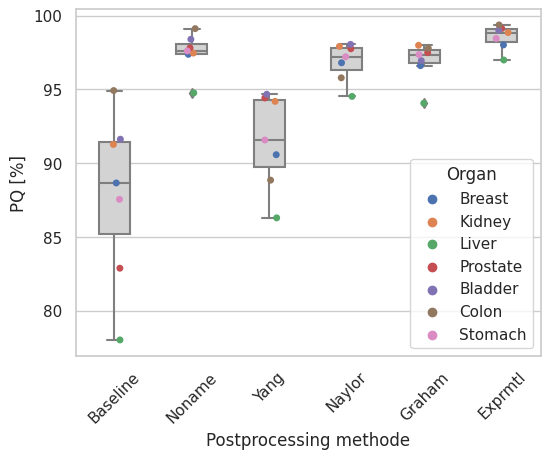

In [119]:
make_performance_boxplot(test_performance_pq)

In [129]:
test_performance_dq = cal_performance_for_score(test_performance_organ_c, score="DQ")
make_pretty_tabel_performance_score(test_performance_dq, "Organwise DQ [%]")

,Baseline,Noname,Yang,Naylor,Graham,Exprmtl
Breast,91.82,98.75,93.77,99.31,98.10,99.44
Kidney,94.67,98.46,96.79,99.56,99.12,100.13
Liver,83.79,97.11,91.89,97.87,96.58,99.12
Prostate,86.89,98.33,96.36,99.15,98.28,99.72
Bladder,94.29,99.22,96.59,99.28,97.86,99.58
Colon,96.41,99.22,90.65,96.96,98.07,99.50
Stomach,91.21,98.69,95.02,99.15,98.39,99.49
Mean [%],91.30,98.54,94.44,98.76,98.06,99.57
Std [%],4.18,0.67,2.25,0.89,0.71,0.28


/tmp/ipykernel_3986958/360704794.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())


<Figure size 800x600 with 0 Axes>

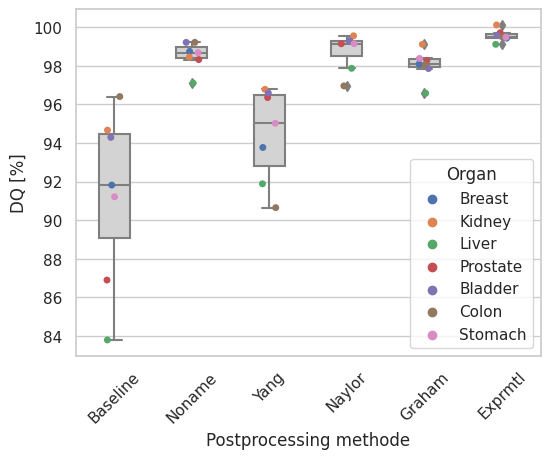

In [124]:
make_performance_boxplot(test_performance_dq, score="DQ")

In [130]:
test_performance_aji = cal_performance_for_score(test_performance_organ_c, score="ModAJI")
make_pretty_tabel_performance_score(test_performance_aji, "Organwise modified AJI [%]")

,Baseline,Noname,Yang,Naylor,Graham,Exprmtl
Breast,82.79,98.42,88.89,97.87,97.45,98.10
Kidney,86.68,98.81,91.62,98.35,98.45,98.26
Liver,62.89,96.23,81.74,96.20,93.26,96.75
Prostate,70.56,99.24,94.25,98.22,97.93,99.23
Bladder,86.12,98.49,93.20,98.61,98.13,98.82
Colon,90.13,99.83,91.98,95.31,99.43,99.81
Stomach,80.27,97.97,87.40,97.76,97.37,97.92
Mean [%],79.92,98.43,89.87,97.47,97.43,98.41
Std [%],9.06,1.06,3.98,1.15,1.82,0.92


/tmp/ipykernel_3986958/360704794.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())


<Figure size 800x600 with 0 Axes>

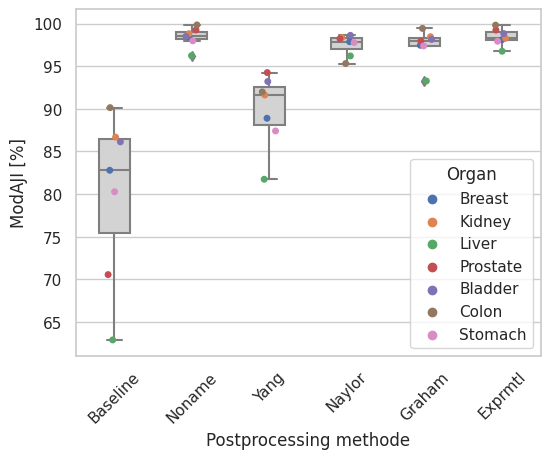

In [131]:
make_performance_boxplot(test_performance_aji, score="ModAJI")

In [132]:
test_performance_sq = cal_performance_for_score(test_performance_organ_c, score="SQ")
make_pretty_tabel_performance_score(test_performance_sq, "Organwise SQ [%]")

,Baseline,Noname,Yang,Naylor,Graham,Exprmtl
Breast,96.55,98.60,96.59,97.47,98.47,98.56
Kidney,96.40,98.98,97.31,98.34,98.85,98.72
Liver,93.11,97.58,93.91,96.57,97.38,97.85
Prostate,95.38,99.47,97.98,98.59,99.19,99.41
Bladder,97.16,99.16,98.00,98.76,99.06,99.43
Colon,98.45,99.89,98.01,98.78,99.70,99.86
Stomach,95.98,98.90,96.36,98.04,98.95,98.95
Mean [%],96.15,98.94,96.88,98.08,98.80,98.97
Std [%],1.53,0.68,1.37,0.75,0.67,0.62


/tmp/ipykernel_3986958/360704794.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())


<Figure size 800x600 with 0 Axes>

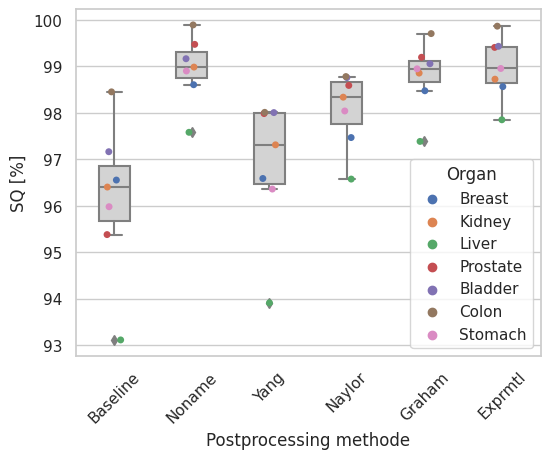

In [133]:
make_performance_boxplot(test_performance_sq, score="SQ")

In [48]:
test_performance = {
    "baseline": {
        "heart": {"PQ": 0.5, "AJI": 0.4},
        "breast": {"PQ": 0.6, "AJI": 0.1},
        "colon": {"PQ": 0.1, "AJI": 0.2},
        "pancrease": {"PQ": 0.8, "AJI": 0.5},
    },
    "yang": {
        "heart": {"PQ": 0.05, "AJI": 0.44},
        "breast": {"PQ": 0.06, "AJI": 0.15},
        "colon": {"PQ": 0.01, "AJI": 0.26},
        "pancrease": {"PQ": 0.08, "AJI": 0.57},
    }
}

In [27]:
mode = ["baseline", "yang"]
score = "PQ"

score_performance = {}
# for m in mode:
#     score_performance[m] = {organ: test_performance[m][organ][score] for organ in test_performance[m]}
# pd.DataFrame(score_performance)
for m in test_performance:
    score_performance[m] = {organ: test_performance[m][organ][score] for organ in test_performance[m]}
pd.DataFrame(score_performance)

,baseline,yang
heart,0.5,0.05
breast,0.6,0.06
colon,0.1,0.01
pancrease,0.8,0.08


In [29]:
{m: {organ: data[score] for organ, data in test_performance[m].items()} for m in mode}

{'baseline': {'heart': 0.5, 'breast': 0.6, 'colon': 0.1, 'pancrease': 0.8},
 'yang': {'heart': 0.05, 'breast': 0.06, 'colon': 0.01, 'pancrease': 0.08}}

In [49]:
cal_performance_for_score(test_performance)

,baseline,yang
heart,0.5,0.05
breast,0.6,0.06
colon,0.1,0.01
pancrease,0.8,0.08


In [20]:
pq_data = {
    'baseline': {key: test_performance['baseline'][key]['PQ'] for key in test_performance['baseline']},
    'yang': {key: test_performance['yang'][key]['PQ'] for key in test_performance['yang']}
}
pq_data = pd.DataFrame(pq_data)
pq_data

,baseline,yang
heart,0.5,0.05
breast,0.6,0.06
colon,0.1,0.01
pancrease,0.8,0.08


In [93]:
sns.load_dataset("tips")

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [106]:
def make_performance_boxplot(performance_for_score: pd.DataFrame, score: str="PQ") -> None:
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    
#     color_labels = []
#     legend_labels = []

#     for algorithm, data in performance_for_score.items():
#         color = sns.color_palette("Set2")[len(color_labels)]
#         sns.boxplot(data=data, color=color)
#         sns.stripplot(data=data, jitter=True, color=".3", label=algorithm)
        
#         # Append the color label and associated legend label
#         color_labels.append(color)
#         legend_labels.append(algorithm)
#     performance_for_score["organ"] = performance_for_score.index
#     
    sns.boxplot(data=performance_for_score,  color=".3")
#     sns.stripplot(data=performance_for_score, jitter=True, color=".3")
    sns.stripplot(data=performance_for_score, hue="organ", jitter=True, palette=sns.color_palette("Set2"))

    
    plt.title(score)
    plt.xlabel("Organ")
    plt.ylabel(score)
    
    # Create a legend with the color labels and legend labels
#     plt.legend(color_labels, legend_labels, title="Postprocessing algorithm")

    plt.show()

In [118]:
test_performance_pq = {'baseline': {'heart': 0.5, 'breast': 0.6, 'colon': 0.1, 'pancrease': 0.8},
 'yang': {'heart': 0.05, 'breast': 0.06, 'colon': 0.01, 'pancrease': 0.08}}
test_performance_pq = pd.DataFrame(test_performance_pq)
test_performance_pq = test_performance_pq.reset_index(names="organ")
test_performance_long = pd.melt(test_performance_pq, id_vars=["organ"], var_name='methode', value_name='score')
test_performance_long

,organ,methode,score
0,heart,baseline,0.50
1,breast,baseline,0.60
2,colon,baseline,0.10
3,pancrease,baseline,0.80
4,heart,yang,0.05
5,breast,yang,0.06
6,colon,yang,0.01
7,pancrease,yang,0.08


In [125]:
def make_performance_boxplot(performance_for_score: pd.DataFrame, score: str="PQ") -> None:
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    sns.boxplot(data=performance_for_score, x="methode", y="score", color=".3")
#     sns.stripplot(data=performance_for_score, jitter=True, color=".3")
    sns.stripplot(data=performance_for_score,x="methode", y="score", hue="organ", jitter=True, palette=sns.color_palette("Set2"))

    
    plt.title(score)
    plt.xlabel("Organ")
    plt.ylabel(score)
    
    # Create a legend with the color labels and legend labels
#     plt.legend(color_labels, legend_labels, title="Postprocessing algorithm")

    plt.show()

/tmp/ipykernel_3763638/76502467.py:7: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=performance_for_score,x="methode", y="score", hue="organ", jitter=True, palette=sns.color_palette("Set2"))


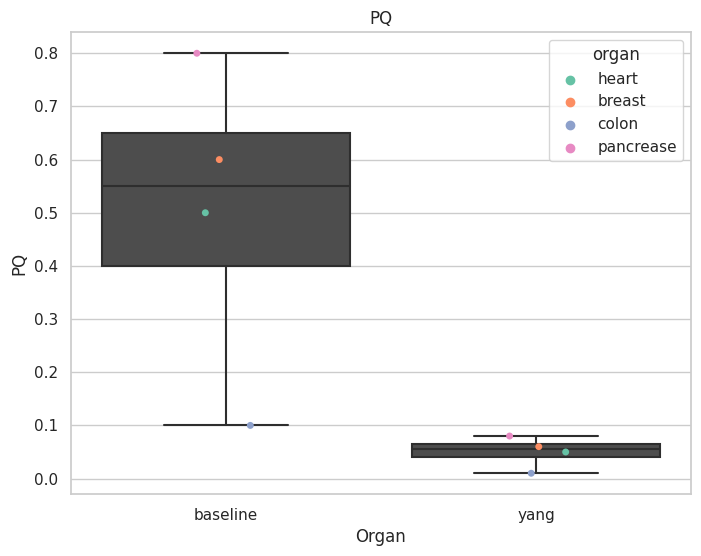

In [126]:
make_performance_boxplot(test_performance_long, score="PQ")

In [109]:
test_performance_pq = {'baseline': {'heart': 0.5, 'breast': 0.6, 'colon': 0.1, 'pancrease': 0.8},
 'yang': {'heart': 0.05, 'breast': 0.06, 'colon': 0.01, 'pancrease': 0.08}}
test_performance_pq = pd.DataFrame(test_performance_pq)
# test_performance_pq["organ"] = test_performance_pq.index
test_performance_pq = test_performance_pq.reset_index(names="organ")
test_performance_pq = pd.wide_to_long(test_performance_pq, i="organ", j)
# print(test_performance_pq)
make_performance_boxplot(test_performance_pq, score="PQ")

TypeError: wide_to_long() missing 3 required positional arguments: 'stubnames', 'i', and 'j'

Index(['heart', 'breast', 'colon', 'pancrease'], dtype='object')


/tmp/ipykernel_3763638/4172022843.py:21: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.scatterplot(data=performance_for_score, palette=sns.color_palette("Set2"))


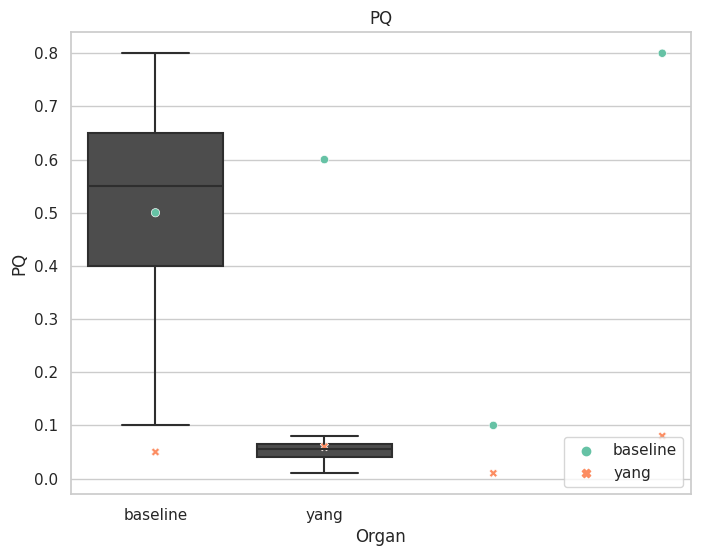

In [92]:
test_performance_pq = {'baseline': {'heart': 0.5, 'breast': 0.6, 'colon': 0.1, 'pancrease': 0.8},
 'yang': {'heart': 0.05, 'breast': 0.06, 'colon': 0.01, 'pancrease': 0.08}}
test_performance_pq = pd.DataFrame(test_performance_pq)
print(test_performance_pq.index)
make_performance_boxplot(test_performance_pq, score="PQ")

In [81]:
def make_performance_box_scatter_plot(performance_data: pd.DataFrame, score: str = "PQ") -> None:
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Create an empty list to hold color labels for the scatterplot
    color_labels = []

    for algorithm, organ_scores in performance_data.items():
        organ_names = list(organ_scores.keys())
        organ_values = list(organ_scores.values())

        # Create a boxplot
        sns.boxplot(x=[algorithm] * len(organ_names), y=organ_values, color="lightgray")
        
        # Create a scatterplot with points colored by organ
        color = sns.color_palette("Set3", n_colors=len(organ_names))
        scatter = sns.stripplot(x=[algorithm] * len(organ_names), y=organ_values, jitter=True, palette=color)
        
        # Add legend labels and corresponding colors
        for i, organ_name in enumerate(organ_names):
            color_labels.append(color[i])
        
        # Set the legend labels
        scatter.legend(organ_names, title="Organs", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"Boxplot and Scatterplot of {score} Values by Algorithm and Organ")
    plt.xlabel("Postprocessing Algorithm")
    plt.ylabel(score)

    # Create a legend for organ colors
    plt.legend(color_labels, organ_names, title="Organs")

    plt.show()

In [83]:
test_performance_pq = {'baseline': {'heart': 0.5, 'breast': 0.6, 'colon': 0.1, 'pancrease': 0.8},
 'yang': {'heart': 0.05, 'breast': 0.06, 'colon': 0.01, 'pancrease': 0.08}}
test_performance_pq = pd.DataFrame(test_performance_pq)
make_performance_box_scatter_plot(test_performance_pq)

TypeError: 'numpy.ndarray' object is not callable

<Figure size 1000x600 with 0 Axes>

In [23]:
batch = next(iter(test_loader))
label = batch["label"]
lookup = {
    "TCGA-E2-A1B5-01Z-00-DX1": "Breast",
    "TCGA-E2-A14V-01Z-00-DX1": "Breast",
    "TCGA-B0-5698-01Z-00-DX1": "Kidney",
    "TCGA-B0-5710-01Z-00-DX1": "Kidney",
    "TCGA-21-5784-01Z-00-DX1": "Liver",
    "TCGA-21-5786-01Z-00-DX1": "Liver",
    "TCGA-CH-5767-01Z-00-DX1": "Prostate",
    "TCGA-G9-6362-01Z-00-DX1": "Prostate",
    "TCGA-DK-A2I6-01A-01-TS1": "Bladder",
    "TCGA-G2-A2EK-01A-02-TSB": "Bladder",
    "TCGA-AY-A8YK-01A-01-TS1": "Colon",
    "TCGA-NH-A8F7-01A-01-TS1": "Colon",
    "TCGA-KB-A93J-01A-01-TS1": "Stomach",
    "TCGA-RD-A8N9-01A-01-TS1": "Stomach"
}
lookup[label[0][:23]]

'Breast'

In [31]:
# label.append("TCGA-B0-5710-01Z-00-DX1_256_1")
organ = set(lookup[l[:23]] for l in label)
dic = {}
dic[next(iter(organ))] = 5
dic

{'Breast': 5}

In [7]:
import numpy as np
performance = {
    "img0_512_0": {"PQ": 0.5, "AJI": 0.4},
    "img0_512_1": {"PQ": 0.6, "AJI": 0.1},
    "img1_512_0": {"PQ": 0.1, "AJI": 0.2},
    "img1_512_1": {"PQ": 0.8, "AJI": 0.5},
    "img2_512_0": {"PQ": 0.4, "AJI": 0.6},
    "img2_512_1": {"PQ": 0.3, "AJI": 0.9},
}
test_performance = {
    "baseline": {
        "img0_512_0": {"PQ": 0.5, "AJI": 0.4},
        "img0_512_1": {"PQ": 0.6, "AJI": 0.1},
        "img1_512_0": {"PQ": 0.1, "AJI": 0.2},
        "img1_512_1": {"PQ": 0.8, "AJI": 0.5},
        "img2_512_0": {"PQ": 0.4, "AJI": 0.6},
        "img2_512_1": {"PQ": 0.3, "AJI": 0.9},
    },
    "yang": {
        "img0_512_0": {"PQ": 0.05, "AJI": 0.44},
        "img0_512_1": {"PQ": 0.06, "AJI": 0.15},
        "img1_512_0": {"PQ": 0.01, "AJI": 0.26},
        "img1_512_1": {"PQ": 0.08, "AJI": 0.57},
        "img2_512_0": {"PQ": 0.04, "AJI": 0.68},
        "img2_512_1": {"PQ": 0.03, "AJI": 0.99},
    }
}
pq_df = pd.DataFrame({k: v['PQ'] for k, v in test_performance.items()})

# Create a DataFrame for AJI values
aji_df = pd.DataFrame({k: v['AJI'] for k, v in test_performance.items()})

print("PQ DataFrame:")
print(pq_df)

print("\nAJI DataFrame:")
print(aji_df)

KeyError: 'PQ'

In [7]:
import pandas as pd

test_performance = {
    "baseline": {
        "img0_512_0": {"PQ": 0.5, "AJI": 0.4},
        "img0_512_1": {"PQ": 0.6, "AJI": 0.1},
        "img1_512_0": {"PQ": 0.1, "AJI": 0.2},
        "img1_512_1": {"PQ": 0.8, "AJI": 0.5},
        "img2_512_0": {"PQ": 0.4, "AJI": 0.6},
        "img2_512_1": {"PQ": 0.3, "AJI": 0.9},
    },
    "yang": {
        "img0_512_0": {"PQ": 0.05, "AJI": 0.44},
        "img0_512_1": {"PQ": 0.06, "AJI": 0.15},
        "img1_512_0": {"PQ": 0.01, "AJI": 0.26},
        "img1_512_1": {"PQ": 0.08, "AJI": 0.57},
        "img2_512_0": {"PQ": 0.04, "AJI": 0.68},
        "img2_512_1": {"PQ": 0.03, "AJI": 0.99},
    }
}

# Create a DataFrame for PQ values
pq_data = {
    'baseline': {key: test_performance['baseline'][key]['PQ'] for key in test_performance['baseline']},
    'yang': {key: test_performance['yang'][key]['PQ'] for key in test_performance['yang']}
}
pq_df = pd.DataFrame(pq_data)

# Create a DataFrame for AJI values
aji_data = {
    'baseline': {key: test_performance['baseline'][key]['AJI'] for key in test_performance['baseline']},
    'yang': {key: test_performance['yang'][key]['AJI'] for key in test_performance['yang']}
}
aji_df = pd.DataFrame(aji_data)

print("PQ DataFrame:")
print(pq_df)

print("\nAJI DataFrame:")
print(aji_df)


PQ DataFrame:
            baseline  yang
img0_512_0       0.5  0.05
img0_512_1       0.6  0.06
img1_512_0       0.1  0.01
img1_512_1       0.8  0.08
img2_512_0       0.4  0.04
img2_512_1       0.3  0.03

AJI DataFrame:
            baseline  yang
img0_512_0       0.4  0.44
img0_512_1       0.1  0.15
img1_512_0       0.2  0.26
img1_512_1       0.5  0.57
img2_512_0       0.6  0.68
img2_512_1       0.9  0.99


In [62]:
test_performance = {
    "baseline": {
        "img0_512_0": {"PQ": 0.5, "AJI": 0.4},
        "img0_512_1": {"PQ": 0.6, "AJI": 0.1},
        "img1_512_0": {"PQ": 0.1, "AJI": 0.2},
        "img1_512_1": {"PQ": 0.8, "AJI": 0.5},
        "img2_512_0": {"PQ": 0.4, "AJI": 0.6},
        "img2_512_1": {"PQ": 0.3, "AJI": 0.9},
    },
    "yang": {
        "img0_512_0": {"PQ": 0.05, "AJI": 0.44},
        "img0_512_1": {"PQ": 0.06, "AJI": 0.15},
        "img1_512_0": {"PQ": 0.01, "AJI": 0.26},
        "img1_512_1": {"PQ": 0.08, "AJI": 0.57},
        "img2_512_0": {"PQ": 0.04, "AJI": 0.68},
        "img2_512_1": {"PQ": 0.03, "AJI": 0.99},
    }
}
lookup = {
    "Breast": ["img0", "img1"],
    "Heart": ["img2"]
}
lookup = {
    "img0": "Breast",
    "img1": "Breast",
    "img2": "Heart"
}

def transform(performance: dict, score: str):
    return {mode: {label: performance[mode][label][score] for label in performance[mode]} for mode in performance}

performance_adapted = transform(test_performance, score="PQ")
pq_data = pd.DataFrame(performance_adapted)

pq_data["organ"] = [lookup[label[:4]] for label in pq_data.index]
group = pq_data.groupby("organ")
df = group.agg(["mean", "std"])
df.index.name = None
df

Styles = [dict(selector = "caption", 
               props = [("color", "black"), 
                        ("text-align", "center")])]
styler = df.style
styler.set_caption("PQ per organ")
styler.format_index(str.capitalize, axis=1)
styler.set_table_styles(Styles)

In [57]:
pq_data["organ"] = [lookup[label[:4]] for label in pq_data.index]
pq_data

,baseline,yang,organ
img0_512_0,0.5,0.05,Breast
img0_512_1,0.6,0.06,Breast
img1_512_0,0.1,0.01,Breast
img1_512_1,0.8,0.08,Breast
img2_512_0,0.4,0.04,Heart
img2_512_1,0.3,0.03,Heart


In [27]:
organ="Breast"
pq_data.filter(regex=f"^{lookup[organ][0]}|{lookup[organ][1]}", axis=0)

,baseline,yang
img0_512_0,0.5,0.05
img0_512_1,0.6,0.06
img1_512_0,0.1,0.01
img1_512_1,0.8,0.08


In [37]:
performance_adapted

{'baseline': {'img0_0': 0.5,
  'img0_1': 0.6,
  'img1_0': 0.1,
  'img1_1': 0.8,
  'img2_0': 0.4,
  'img2_1': 0.3},
 'yang': {'img0_0': 0.05,
  'img0_1': 0.06,
  'img1_0': 0.01,
  'img1_1': 0.08,
  'img2_0': 0.04,
  'img2_1': 0.03}}

In [5]:
lookup = {
    "TCGA-E2-A1B5-01Z-00-DX1": "Breast",
    "TCGA-E2-A14V-01Z-00-DX1": "Breast",
    "TCGA-B0-5698-01Z-00-DX1": "Kidney",
    "TCGA-B0-5710-01Z-00-DX1": "Kidney",
    "TCGA-21-5784-01Z-00-DX1": "Liver",
    "TCGA-21-5786-01Z-00-DX1": "Liver",
    "TCGA-CH-5767-01Z-00-DX1": "Prostate",
    "TCGA-G9-6362-01Z-00-DX1": "Prostate",
    "TCGA-DK-A2I6-01A-01-TS1": "Bladder",
    "TCGA-G2-A2EK-01A-02-TSB": "Bladder",
    "TCGA-AY-A8YK-01A-01-TS1": "Colon",
    "TCGA-NH-A8F7-01A-01-TS1": "Colon",
    "TCGA-KB-A93J-01A-01-TS1": "Stomach",
    "TCGA-RD-A8N9-01A-01-TS1": "Stomach"
}

In [12]:
lookup = {
    "Breast": ["TCGA-E2-A1B5-01Z-00-DX1", "TCGA-E2-A14V-01Z-00-DX1"],
    "Kidney": ["TCGA-B0-5698-01Z-00-DX1", "TCGA-B0-5710-01Z-00-DX1"],
    "Liver": ["TCGA-21-5784-01Z-00-DX1", "TCGA-21-5786-01Z-00-DX1"],
    "Prostate": ["TCGA-CH-5767-01Z-00-DX1", "TCGA-G9-6362-01Z-00-DX1"],
    "Bladder": ["TCGA-DK-A2I6-01A-01-TS1", "TCGA-G2-A2EK-01A-02-TSB"],
    "Colon": ["TCGA-AY-A8YK-01A-01-TS1", "TCGA-NH-A8F7-01A-01-TS1"],
    "Stomach": ["TCGA-KB-A93J-01A-01-TS1", "TCGA-RD-A8N9-01A-01-TS1"]
    
}

In [3]:
for organ, wsi in lookup.items():
    

False

In [14]:
performance = test_performance
{mode: {organ: [[performance[mode][label]["PQ"] for label in performance[mode] if label[:23]==wsi_label] for wsi_label in wsi] for organ, wsi in lookup.items()} for mode in performance}

{'baseline': {'Breast': [[], []],
  'Kidney': [[], []],
  'Liver': [[], []],
  'Prostate': [[], []],
  'Bladder': [[], []],
  'Colon': [[], []],
  'Stomach': [[], []]},
 'yang': {'Breast': [[], []],
  'Kidney': [[], []],
  'Liver': [[], []],
  'Prostate': [[], []],
  'Bladder': [[], []],
  'Colon': [[], []],
  'Stomach': [[], []]}}

In [48]:
len("TCGA-E2-A1B5-01Z-00-DX1")
s = "TCGA-DK-A2I6-01A-01-TS1_256_15"[:23]
s

'TCGA-DK-A2I6-01A-01-TS1'

In [6]:
data = {
    'baseline': {
        'img0_0': 0.5, 'img0_1': 0.6,
        'img1_0': 0.1, 'img1_1': 0.8,
        'img2_0': 0.4, 'img2_1': 0.3
    },
    'yang': {
        'img0_0': 0.05, 'img0_1': 0.06,
        'img1_0': 0.01, 'img1_1': 0.08,
        'img2_0': 0.04, 'img2_1': 0.03
    }
}
[data]

{'baseline': {'img0_0': 0.5,
  'img0_1': 0.6,
  'img1_0': 0.1,
  'img1_1': 0.8,
  'img2_0': 0.4,
  'img2_1': 0.3},
 'yang': {'img0_0': 0.05,
  'img0_1': 0.06,
  'img1_0': 0.01,
  'img1_1': 0.08,
  'img2_0': 0.04,
  'img2_1': 0.03}}

In [43]:
import pandas as pd

# Provided data
data = {
    'baseline': {
        'img0_0': 0.5, 'img0_1': 0.6,
        'img1_0': 0.1, 'img1_1': 0.8,
        'img2_0': 0.4, 'img2_1': 0.3
    },
    'yang': {
        'img0_0': 0.05, 'img0_1': 0.06,
        'img1_0': 0.01, 'img1_1': 0.08,
        'img2_0': 0.04, 'img2_1': 0.03
    }
}

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate mean and std for each organ and each method
organ_a_baseline_mean = df.loc[['img0_0', 'img0_1', 'img2_0', 'img2_1'], 'baseline'].mean()
organ_a_baseline_std = df.loc[['img0_0', 'img0_1', 'img2_0', 'img2_1'], 'baseline'].std()
organ_a_yang_mean = df.loc[['img0_0', 'img0_1', 'img2_0', 'img2_1'], 'yang'].mean()
organ_a_yang_std = df.loc[['img0_0', 'img0_1', 'img2_0', 'img2_1'], 'yang'].std()

organ_b_baseline_mean = df.loc[['img1_0', 'img1_1'], 'baseline'].mean()
organ_b_baseline_std = df.loc[['img1_0', 'img1_1'], 'baseline'].std()
organ_b_yang_mean = df.loc[['img1_0', 'img1_1'], 'yang'].mean()
organ_b_yang_std = df.loc[['img1_0', 'img1_1'], 'yang'].std()

# Create a summary DataFrame
summary_data = {
    'Organ A (Baseline Mean)': [organ_a_baseline_mean],
    'Organ A (Baseline Std)': [organ_a_baseline_std],
    'Organ A (Yang Mean)': [organ_a_yang_mean],
    'Organ A (Yang Std)': [organ_a_yang_std],
    'Organ B (Baseline Mean)': [organ_b_baseline_mean],
    'Organ B (Baseline Std)': [organ_b_baseline_std],
    'Organ B (Yang Mean)': [organ_b_yang_mean],
    'Organ B (Yang Std)': [organ_b_yang_std]
}

pd.DataFrame(summary_data)



,Organ A (Baseline Mean),Organ A (Baseline Std),Organ A (Yang Mean),Organ A (Yang Std),Organ B (Baseline Mean),Organ B (Baseline Std),Organ B (Yang Mean),Organ B (Yang Std)
0,0.45,0.129099,0.045,0.01291,0.45,0.494975,0.045,0.049497


In [ ]:
pq_data

/home/ubuntu/NucInstSeg/venv/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


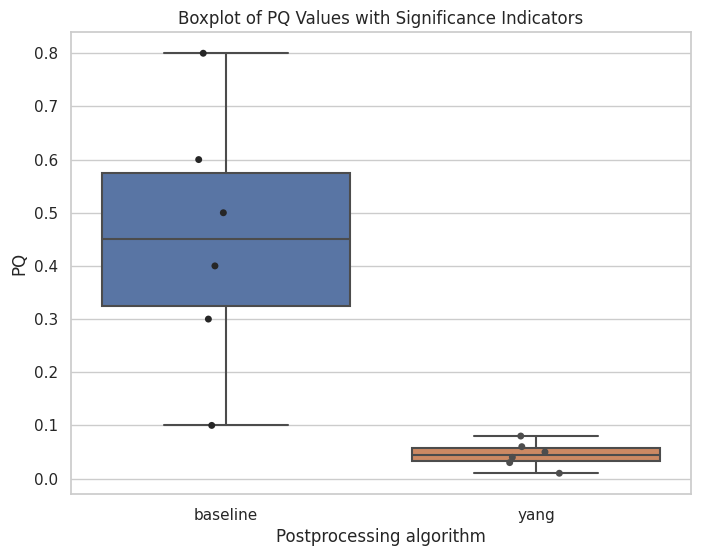

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Create a boxplot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.boxplot(data=pq_data)
sns.stripplot(data=pq_data, jitter=True, color=".3")

# Perform the Wilcoxon signed-rank test and annotate with significance indicators
significance_level = 0.05

# Create an empty list to store p-values
p_values = []

# Iterate over unique groups
groups = pq_data.columns

# for group in groups:
#     data_group = pq_data[pq_data['group'] == group]
#     data_baseline = pq_data[pq_data['group'] == 'baseline']
    
#     # Perform one-sided Wilcoxon signed-rank test
#     _, p_value = stats.wilcoxon(data_group, data_baseline, alternative='greater')
#     p_values.append(p_value)
    
#     # Add significance indicators (asterisks)
#     if p_value < alpha:
#         plt.text(groups.tolist().index(group), max(pq_data["PQ"]) + 0.05, "*", ha='center', va='center', fontsize=12)

# # Display the p-values (optional)
# p_values_df = pd.DataFrame({'group': groups, 'p_value': p_values})
# print("P-values:")
# print(p_values_df)

plt.title("Boxplot of PQ Values with Significance Indicators")
plt.xlabel("Postprocessing algorithm")
plt.ylabel("PQ")

plt.show()


In [ ]:
def adapt(performance: dict, score: str):
    return {mode: {label: performance[mode][label][score] for label in performance[mode]} for mode in performance}

In [ ]:
def style_pprocess_params_df(df: DataFrame, caption: str) -> Styler:
    styler = df.style 
    df.index = [s.replace("_cat", "").replace("_float", "") for s in df.index]
    styler.set_caption("Postprocessing parameter")
    styler.format_index(str.capitalize, axis=1)
    styler.format(precision=2)
    styler.hide([s for s in df.index if "_is" in s])
    return styler

In [ ]:
# dummy = {"mode0": {"score0": torch.tensor(0.5566), "score1": torch.tensor(0.9956)}, "mode1": {"score0": torch.tensor(0.7176), "score1": torch.tensor(0.1116)}}
dummy = {"mode0": {"min_marker_size": 55, "min_obj_size": 20, "thresh_comb_float": 0.6, "thresh_comb_is_scalar": True, "thresh_seg_cat": "yen", "thresh_seg_is_scalar": 0.5}}
df = pd.DataFrame(dummy)
style_pprocess_params_df(df, "Hello")

In [ ]:
eval_pprocesses()

In [ ]:
PParamsTuner(mode="baseline", dataloader=val_loader, n_trials=5)()

In [ ]:
pprocess_params = {
    "thresh_seg": 0.5,
    "min_obj_size": 0
 }
scores = postprocess_gt(mode="baseline", pprocess_params=pprocess_params, dataloader=val_loader)
print(scores)

In [ ]:
loader = test_loader
postprocesses = {
    "baseline": SegPostProcess(seg_thresh=0.5, actv=False, mode="baseline"),
    "noname": SegPostProcess(seg_thresh=0.5, cont_thresh=0.5, actv=False, mode="noname"),
    "yang": SegPostProcess(seg_thresh=0.5, thresh_coarse=250, thresh_fine=100, actv=False, mode="yang"),
    "naylor": DistPostProcess(param=3, thresh=0),
    "graham": HVPostProcess(seg_thresh=0.5, actv=False),
    "exprmtl": HVPostProcess(seg_thresh=0.5, actv=False, exprmtl=True)
}
metrics = {
    "baseline": [DSC(), ModAJI(), PQ()],
    "noname": [DSC(), ModAJI(), PQ()],
    "yang": [DSC(), ModAJI(), PQ()],
    "naylor": [DSC(), ModAJI(), PQ()],
    "graham": [DSC(), ModAJI(), PQ()],
    "exprmtl": [DSC(), ModAJI(), PQ()]
}

for gt in tqdm(loader):
    for name, process in postprocesses.items():
        pred_inst = process(gt)
        for metric in metrics[name]:
            metric.update(pred_inst, gt["inst"])

scores = defaultdict(list)
for name in metrics.keys():
    for metric in metrics[name]:
        submetrics = metric.compute()
        for score in submetrics.values():
            scores[name.capitalize()].append(float(score))

In [ ]:
df = pd.DataFrame(scores, index=["DSC", "ModAJI", "DQ", "SQ", "PQ"])
df

In [ ]:
df = pd.DataFrame(scores, index=["DSC", "ModAJI", "DQ", "SQ", "PQ"])
df

In [ ]:
idx = 7
plots_per_row = 4
gt = next(iter(loader))
num_plots = len(postprocesses.keys()) + 2 
num_rows = -(num_plots // -plots_per_row)
num_cols = num_plots if num_rows == 1 else plots_per_row
plt.figure(figsize=(num_cols*4, num_rows*4))
plt.subplot(num_rows, num_cols, 1)
plt.imshow(Picture.from_tensor(gt["img"][idx]).data)
plt.title("Image")
plt.axis("off")
plt.subplot(num_rows, num_cols, 2)
plt.imshow(Picture.create_colored_inst(gt["inst"][idx]))
plt.title("Ground truth")
plt.axis("off")
for position, (name, process) in enumerate(postprocesses.items(), start=3):
        pred_inst = process(gt)
        plt.subplot(num_rows, num_cols, position)
        plt.imshow(Picture.create_colored_inst(pred_inst[idx]))
        plt.title(name.capitalize())    
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
ncols = 2
data_module.batch_size=ncols
val_loader = data_module.val_dataloader()
nrows=len(postprocesses.keys()) + 2 
gt = next(iter(val_loader))

background = torch.zeros((256,256), dtype=bool)   
plt.figure(figsize=(5, 20))
for col, img in enumerate(gt["img"], start=1):
    plt.subplot(nrows, ncols, col)
    plt.imshow(Picture.from_tensor(img).data)
#     plt.title("Image")
    plt.axis("off")
for col, gt_inst in enumerate(gt["inst"], start=1):
    plt.subplot(nrows, ncols, col+ncols)
    plt.imshow(Picture.from_tensor(background, gt_inst).data)
#     plt.title("Ground truth")
    plt.axis("off")
for row, (name, process) in enumerate(postprocesses.items(), start=1):
    pred = process(gt)
    for col, pred_inst in enumerate(pred, start=1):
        plt.subplot(nrows, ncols, row*ncols+col+2)
        plt.imshow(Picture.from_tensor(background, pred_inst).data)
        plt.axis("off")
#         plt.title(name.capitalize())    
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Set the desired figure size (width, height) in inches
figure_width = 5  # Adjust as needed
figure_height = 20  # Adjust as needed

ncols = 2
data_module.batch_size = ncols
val_loader = data_module.val_dataloader()
nrows = len(postprocesses.keys()) + 2
gt = next(iter(val_loader))

background = torch.zeros((256, 256), dtype=bool)

# Create a new figure with the desired size
plt.figure(figsize=(figure_width, figure_height))

# Create a gridspec layout
gs = gridspec.GridSpec(nrows, ncols * 2, width_ratios=[1, 1] * ncols, hspace=0.3)

for col, img in enumerate(gt["img"], start=0):
    ax = plt.subplot(gs[0, col * 2])
    ax.imshow(Picture.from_tensor(img).data)
    ax.axis("off")

for col, gt_inst in enumerate(gt["inst"], start=0):
    ax = plt.subplot(gs[1, col * 2])
    ax.imshow(Picture.from_tensor(background, gt_inst).data)
    ax.axis("off")

for row, (name, process) in enumerate(postprocesses.items(), start=2):
    pred = process(gt)
    for col, pred_inst in enumerate(pred, start=0):
        ax = plt.subplot(gs[row, col * 2])
        ax.imshow(Picture.from_tensor(background, pred_inst).data)
        ax.axis("off")

# Add column titles above each column
for col in range(ncols):
    ax = plt.subplot(gs[0, col * 2])
    ax.set_title(f"Column {col + 1}")

# Add row titles to the left of each row
row_names = ["Image", "Ground truth"] + [name.capitalize() for name in postprocesses.keys()]
for row, name in enumerate(row_names, start=0):
    ax = plt.subplot(gs[row, 0])
    ax.annotate(name, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0), textcoords='offset points',
                va='center', ha='right')

plt.tight_layout()  # Helps improve subplot spacing
plt.show()